In [2]:
from __future__ import division
import tt
import numpy as np
import time
import matplotlib.pyplot as plt
import os, sys 
sys.path.insert(0,os.path.pardir)
from Bayes_util.lib.bayes_lib import create_rank_one_tensor_from_vector, evaluate
from Bayes_util.lib.interpolation_util import evaluate_function_representation, get_cheb_points
                                             
%matplotlib inline

In [3]:
def apply_inner_product_old(_ten_list_old, measurements, gamma, precision, maxrank, _print=False):
    
    for lia in range(len(_ten_list_old)):
        value = create_rank_one_tensor_from_vector(measurements[lia], _ten_list_old[lia].n)
        _ten_list_old[lia] = value - _ten_list_old[lia]
    #print "ten_list:{}".format(ten_list)
    buffer_list = [t1*t2*gamma**(-1) for t1, t2 in zip(_ten_list_old, _ten_list_old)]
    #print "buffer_list:{}".format(buffer_list)
    tensor = buffer_list[0]
    for lia in range(1, len(buffer_list)):
        if _print:
            print tensor
        if max(tensor.r) > maxrank:
            if _print:
                print "round tensor of rank {0}".format(tensor.r)
            #tensor = tt.vector.round(tensor, precision, maxrank)
            if _print:
                print "tensor rounded to rank {0}".format(tensor.r)
            
        tensor += buffer_list[lia]

    return tensor

In [4]:
def apply_inner_product_new(_ten_list_new, measurements, gamma, precision, maxrank, _print=True):
    
    value1 = create_rank_one_tensor_from_vector(0, _ten_list_new[0].n)*(len(measurements)-1)
    value2 = create_rank_one_tensor_from_vector(np.sum([measurements[lia]**2 for lia in range(len(measurements))]),
                                                _ten_list_new[0].n)
    value = value1 + value2
    
    tensor1_sum = tt.vector.to_list(tt.vector.copy(_ten_list_new[0]))
    assert tensor1_sum[0].shape[0] == 1
    assert tensor1_sum[0].shape[1] == 1
    
    tensor1_sum[0][0,0,:] = [0 for _ in range(tensor1_sum[0].shape[2])]
    tensor1_sum = tt.vector.from_list(tensor1_sum)
    tensor1_sum *= len(measurements)-1
    
    tensor1_first = tt.vector.to_list(tt.vector.copy(_ten_list_new[0]))
    tensor1_first[0][0,0,:] = np.sum([tt.vector.to_list(_ten_list_new[lia])[0][0,0,:]*measurements[lia]
                                      for lia in range(len(_ten_list_new))], axis=0)
    
    tensor1_first = tt.vector.from_list(tensor1_first)

    tensor1 = tensor1_sum + tensor1_first
    
    tensor2 = _ten_list_new[0]*_ten_list_new[0]
    for lia in range(1, len(measurements)):
        if max(tensor2.r) > maxrank:
            if _print:
                print "round tensor of rank {0}".format(tensor2.r)
            #tensor2 = tt.vector.round(tensor2, precision, maxrank)
            if _print:
                print "tensor rounded to rank {0}".format(tensor2.r)
        tensor2 += _ten_list_new[lia]*_ten_list_new[lia]
        
    #print "tensor0.rank = {}".format(value.r)
    #print "tensor1.rank = {}".format(tensor1.r)
    #print "tensor2.rank = {}".format(tensor2.r)
            
    return gamma**(-1)*(value - 2*tensor1 + tensor2)

old. needed time: 0.415373086929
old. resulting ranks: [   1 6760  160  250  160   90    1]
new needed time: 0.309843063354
new resulting ranks: [   1 6302   98  170   98   46    1]


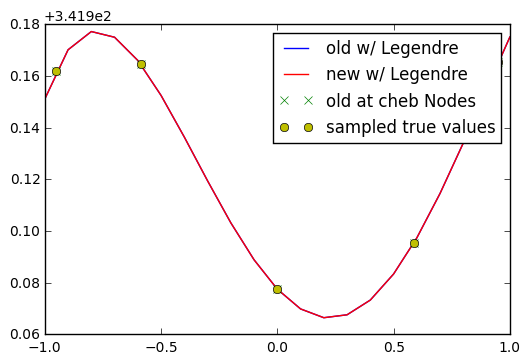

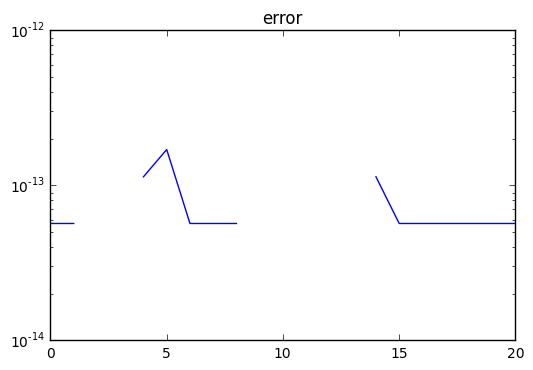

In [5]:
observation_nodes = 10                                             # set the number of observations
cheb_dim = [5]                                                     # define number of nodes in the stochastic grid
#                                                                  # WARNING: Kernel interrups when > 6 due to tensor max value
cheb_points = get_cheb_points(cheb_dim)[0]                         # get the nodes
#                                                                  # first components contains the observation info
dimensions = [observation_nodes]+[cheb_dim[0] for _ in range(5)]
ranks = [1,25,3,4,3,2,1]                                            # we need len(dimensions)+1 many ranks

gamma = 0.01
precision = 1e-10
measurements = np.random.rand(observation_nodes)                    # create random measurements just to illustrate procedure
#print "measurements: {}".format(measurements)
ten = tt.rand(dimensions,len(dimensions),ranks)                     # create random tensor. Assume observation is done
ten = ten * tt.vector.norm(ten)**(-1)
ten_orig = tt.vector.copy(ten)
ten = tt.vector.to_list(ten)
ten_list = []                                                       # list of observations
for lia in range(observation_nodes):                                # create the list of tt tensors over all observations
    buffer_list = []                                                # buffer needed for tensor creation
    buffer_list.append(np.zeros((1,1,ten[0].shape[2])))             # init first component with zeros
    buffer_list[-1][0,:,:] = np.array(ten[0][0,lia,:])              # set dimension 2 & 3 of first component
    for lic in range(1, len(dimensions)):                           # loop through the remaining component tensors
        buffer_list.append(np.array(ten[lic]))                      # add them to the list
    ten_list.append(tt.vector.from_list(buffer_list))               # add new tensor with n[0] = 1 representing observations
    
N = 10
x = np.arange(-1,1+1/N, 1/N)                                        # define sampling grid, in each dimension equdistant
maxrank = 20                                                        # define maximal rank to round at

assert len(measurements) == len(ten_list)
start_old = time.time()
ten_old = apply_inner_product_old([ten_list[lia].copy() for lia in range(len(ten_list))], measurements, gamma, precision, maxrank, _print=False)
end_old = time.time()

print "old. needed time: {}".format(end_old - start_old)
print "old. resulting ranks: {}".format(ten_old.r)

start_new = time.time()
ten_new = apply_inner_product_new([ten_list[lia].copy() for lia in range(len(ten_list))], measurements, gamma, precision, maxrank, _print=False)
end_new = time.time()

print "new needed time: {}".format(end_new - start_new)
print "new resulting ranks: {}".format(ten_new.r)

values_ten_old = [evaluate(ten_old, _poly="Lagrange", 
                          _samples=[0,cheb_points[1],x[lia],cheb_points[2],cheb_points[2],cheb_points[3]]) 
                                    for lia in range(0, len(x))]
values_ten_new = [evaluate(ten_new, _poly="Lagrange", 
                          _samples=[0,cheb_points[1],x[lia],cheb_points[2],cheb_points[2],cheb_points[3]]) 
                                    for lia in range(0, len(x))]

values_ten_sampled = []
#values_tenLag = [evaluate(ten, cheb_points, _poly="Lagrange", 
#                          _samples=[0,cheb_points[10],x[lia],cheb_points[12],cheb_points[2],cheb_points[3]]) 
#                                    for lia in range(0, len(x))]
values_orig = []
for lia in range(len(cheb_points)):
    values_orig.append(gamma**(-1)*np.sum([(measurements[lic]-ten_list[lic][0, 1, lia, 2, 2, 3])**2 for lic in range(len(measurements))]))
    
values_ten = [ten_old[0,1,lia,2,2,3] for lia in range(ten_old.n[2])]

#plt.plot(x, values_tenLag, '-r', label='interpolated w/ Lagrange')
plt.plot(x, values_ten_old, '-b', label='old w/ Legendre')
plt.plot(x, values_ten_new, '-r', label='new w/ Legendre')
plt.plot(cheb_points, values_ten, 'xg', label='old at cheb Nodes')
plt.plot(cheb_points, values_orig, 'oy', label='sampled true values')
plt.legend()
plt.show()
plt.figure()
plt.semilogy(np.abs(np.array(values_ten_new) - np.array(values_ten_old)))
plt.title("error")
plt.show()

old. needed time: 3.64880108833
old. resulting ranks: [    1 13520   320   500   320   180     1]
new needed time: 0.966959953308
new resulting ranks: [    1 12552   188   330   188    86     1]


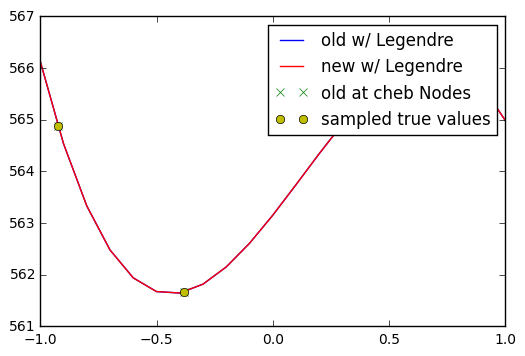

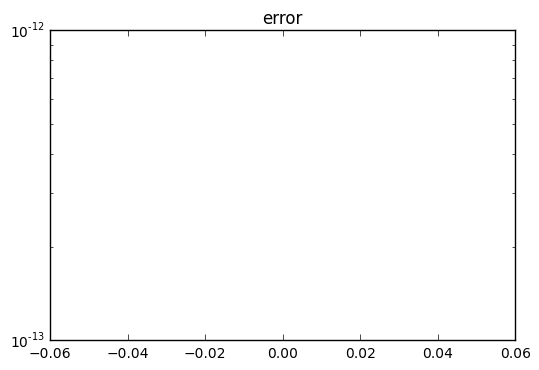

In [8]:
from Bayes_util.lib.bayes_lib import apply_bayes_inner_product_new
observation_nodes = 20                                             # set the number of observations
cheb_dim = [4]                                                     # define number of nodes in the stochastic grid
#                                                                  # WARNING: Kernel interrups when > 6 due to tensor max value
cheb_points = get_cheb_points(cheb_dim)[0]                         # get the nodes
#                                                                  # first components contains the observation info
dimensions = [observation_nodes]+[cheb_dim[0] for _ in range(5)]
ranks = [1,25,3,4,3,2,1]                                            # we need len(dimensions)+1 many ranks

gamma = 0.01
precision = 1e-10
measurements = np.random.rand(observation_nodes)                    # create random measurements just to illustrate procedure
#print "measurements: {}".format(measurements)
ten = tt.rand(dimensions,len(dimensions),ranks)                     # create random tensor. Assume observation is done
ten = ten * tt.vector.norm(ten)**(-1)
ten_orig = tt.vector.copy(ten)
ten = tt.vector.to_list(ten)
ten_list = []                                                       # list of observations
for lia in range(observation_nodes):                                # create the list of tt tensors over all observations
    buffer_list = []                                                # buffer needed for tensor creation
    buffer_list.append(np.zeros((1,1,ten[0].shape[2])))             # init first component with zeros
    buffer_list[-1][0,:,:] = np.array(ten[0][0,lia,:])              # set dimension 2 & 3 of first component
    for lic in range(1, len(dimensions)):                           # loop through the remaining component tensors
        buffer_list.append(np.array(ten[lic]))                      # add them to the list
    ten_list.append(tt.vector.from_list(buffer_list))               # add new tensor with n[0] = 1 representing observations
    
N = 10
x = np.arange(-1,1+1/N, 1/N)                                        # define sampling grid, in each dimension equdistant
maxrank = 20                                                        # define maximal rank to round at

assert len(measurements) == len(ten_list)
start_old = time.time()
ten_old = apply_inner_product_old([ten_list[lia].copy() for lia in range(len(ten_list))], measurements, gamma, precision, maxrank, _print=False)
end_old = time.time()

print "old. needed time: {}".format(end_old - start_old)
print "old. resulting ranks: {}".format(ten_old.r)

start_new = time.time()
ten_new = apply_bayes_inner_product_new([ten_list[lia].copy() for lia in range(len(ten_list))], measurements, gamma, precision, maxrank, _print=False, n_cpu=1)
end_new = time.time()

print "new needed time: {}".format(end_new - start_new)
print "new resulting ranks: {}".format(ten_new.r)

values_ten_old = [evaluate(ten_old, _poly="Lagrange", 
                          _samples=[0,cheb_points[1],x[lia],cheb_points[2],cheb_points[2],cheb_points[3]]) 
                                    for lia in range(0, len(x))]
values_ten_new = [evaluate(ten_new, _poly="Lagrange", 
                          _samples=[0,cheb_points[1],x[lia],cheb_points[2],cheb_points[2],cheb_points[3]]) 
                                    for lia in range(0, len(x))]

values_ten_sampled = []
#values_tenLag = [evaluate(ten, cheb_points, _poly="Lagrange", 
#                          _samples=[0,cheb_points[10],x[lia],cheb_points[12],cheb_points[2],cheb_points[3]]) 
#                                    for lia in range(0, len(x))]
values_orig = []
for lia in range(len(cheb_points)):
    values_orig.append(gamma**(-1)*np.sum([(measurements[lic]-ten_list[lic][0, 1, lia, 2, 2, 3])**2 for lic in range(len(measurements))]))
    
values_ten = [ten_old[0,1,lia,2,2,3] for lia in range(ten_old.n[2])]

#plt.plot(x, values_tenLag, '-r', label='interpolated w/ Lagrange')
plt.plot(x, values_ten_old, '-b', label='old w/ Legendre')
plt.plot(x, values_ten_new, '-r', label='new w/ Legendre')
plt.plot(cheb_points, values_ten, 'xg', label='old at cheb Nodes')
plt.plot(cheb_points, values_orig, 'oy', label='sampled true values')
plt.legend()
plt.show()
plt.figure()
plt.semilogy(np.max([[1e-15]*len(values_ten_new), np.abs(np.array(values_ten_new) - np.array(values_ten_old))]))
plt.title("error")
plt.show()